In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [38]:
import TDkit as kit
from td.client import TDClient
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import os
import datetime
import operator
sns.set(style='whitegrid', font_scale=5, rc={'figure.figsize':(25,25)})

In [4]:
kit.login()

Importing List of Ticker Symbols

In [3]:
SPACs=pd.read_csv('./SPACs.csv')
IPOs=pd.read_csv('./IPOs.csv')
Completed_SPACs=pd.read_csv('./Completed SPACs.csv')

Pulling Closing Prices

In [6]:
SPAC_returns=kit.Port_consol(SPACs, 2, limit_speed=True)
IPO_returns=kit.Port_consol(IPOs, 2, limit_speed=True)
Post_merge_SPAC_returns=kit.Port_consol(Completed_SPACs, 2, limit_speed=True)

In [83]:
Completed_SPAC_returns=kit.yf_historical_close(Completed_SPACs, start='2020-01-02', end='2020-12-31', interval='1d')

- UK: No data found for this date range, symbol may be delisted


Saving Returns to CSV for Ease of Access, then Re-importing

In [233]:
SPAC_returns.dropna(how='all', axis=1).to_csv('./SPAC Returns.csv')
IPO_returns.dropna(how='all', axis=1).to_csv('./IPO Returns.csv')
Post_merge_SPAC_returns.dropna(how='all', axis=1).to_csv('./Post Merge SPAC Returns.csv')
Completed_SPAC_returns.dropna(how='all', axis=1).to_csv('./Completed SPAC Returns.csv')

In [4]:
SPAC_returns=pd.read_csv('./SPAC Returns.csv', index_col='Date', parse_dates=True)
SPAC_returns.index=SPAC_returns.index.normalize()
IPO_returns=pd.read_csv('./IPO Returns.csv', index_col='Date', parse_dates=True)
IPO_returns.index=IPO_returns.index.normalize()
Post_merge_SPAC_returns=pd.read_csv('./Post Merge SPAC Returns.csv', index_col='Date', parse_dates=True)
Post_merge_SPAC_returns.index=Post_merge_SPAC_returns.index.normalize()
Completed_SPAC_returns=pd.read_csv('./Completed SPAC Returns.csv', index_col='Date', parse_dates=True)
Completed_SPAC_returns.index=Completed_SPAC_returns.index.normalize()

In [5]:
SP_returns=pd.read_csv('./SP500.csv', index_col='DATE')
SP_returns.index.names=['Date']
SP_returns.index=pd.to_datetime(SP_returns.index)
SP_returns.replace('.', np.nan, inplace=True)
SP_returns['SP500']=SP_returns['SP500'].astype('float')

Trimming Closing Prices to 2020 Time Period Only

In [6]:
SPAC_returns=SPAC_returns['2020-01-01 06:00:00':'2020-12-31 06:00:00']
IPO_returns=IPO_returns['2020-01-01 06:00:00':'2020-12-31 06:00:00']
Post_merge_SPAC_returns=Post_merge_SPAC_returns['2020-01-01 06:00:00':'2020-12-31 06:00:00']

In [7]:
All_SPAC_returns=pd.concat([SPAC_returns, Completed_SPAC_returns], axis=1)

Converting Closing Prices to Percentage Change

In [8]:
def to_pct(returns):
    df_pct=returns.pct_change()
    df_pct.replace(0, np.nan, inplace=True)
    return df_pct
SPACs_pct=to_pct(SPAC_returns)
IPOs_pct=to_pct(IPO_returns)
Completed_SPACs_pct=to_pct(Completed_SPAC_returns)
Post_merge_SPACs_pct=to_pct(Post_merge_SPAC_returns)
All_SPACs_pct=to_pct(All_SPAC_returns)
SP_pct=to_pct(SP_returns)

Calculating Daily Cumulative Returns

In [9]:
def cum_pct(pct_returns):
    return ((1+pct_returns).cumprod()-1)*100
SPACs_daily_cum_pct=cum_pct(SPACs_pct)
IPOs_daily_cum_pct=cum_pct(IPOs_pct)
Completed_SPACs_daily_cum_pct=cum_pct(Completed_SPACs_pct)
Post_merge_SPACs_daily_cum_pct=cum_pct(Post_merge_SPACs_pct)
All_SPACs_daily_cum_pct=cum_pct(All_SPACs_pct)
SP_daily_cum_pct=cum_pct(SP_pct)

Finding Total Cumulative Return

In [10]:
def total_cum_return(daily_cum_return_df): 
    cum_list=[]
    for i in daily_cum_return_df:
        series=pd.Series(daily_cum_return_df[i], index=daily_cum_return_df.index)
        last_valid_index=series.last_valid_index()
        try:
            cum_series=pd.Series(data=series[last_valid_index], name=i, index=['Cumulative Return'])
            cum_list.append(cum_series)
        except Exception:
            continue
    return pd.DataFrame(cum_list)
SPACs_total_cum_return=total_cum_return(SPACs_daily_cum_pct)
IPOs_total_cum_return=total_cum_return(IPOs_daily_cum_pct)
Completed_SPACs_total_cum_return=total_cum_return(Completed_SPACs_daily_cum_pct)
Post_merge_SPACs_total_cum_return=total_cum_return(Post_merge_SPACs_daily_cum_pct)
All_SPACs_total_cum_return=total_cum_return(All_SPACs_daily_cum_pct)
SP_total_cum_return=total_cum_return(SP_daily_cum_pct)

Calculating Mean Percentage Change for Each Class

In [11]:
def mean_pct(cum_pct_full):
    return cum_pct_full.mean(axis=1).dropna()
SPACs_daily_mean_pct=mean_pct(SPACs_daily_cum_pct)
IPOs_daily_mean_pct=mean_pct(IPOs_daily_cum_pct)
Completed_SPACs_daily_mean_pct=mean_pct(Completed_SPACs_daily_cum_pct)
Post_merge_SPACs_daily_mean_pct=mean_pct(Post_merge_SPACs_daily_cum_pct)
All_SPACs_daily_mean_pct=mean_pct(All_SPACs_daily_cum_pct)
SP_mean_daily_pct=mean_pct(SP_daily_cum_pct)

Calculating Cumulative Returns for Each Class

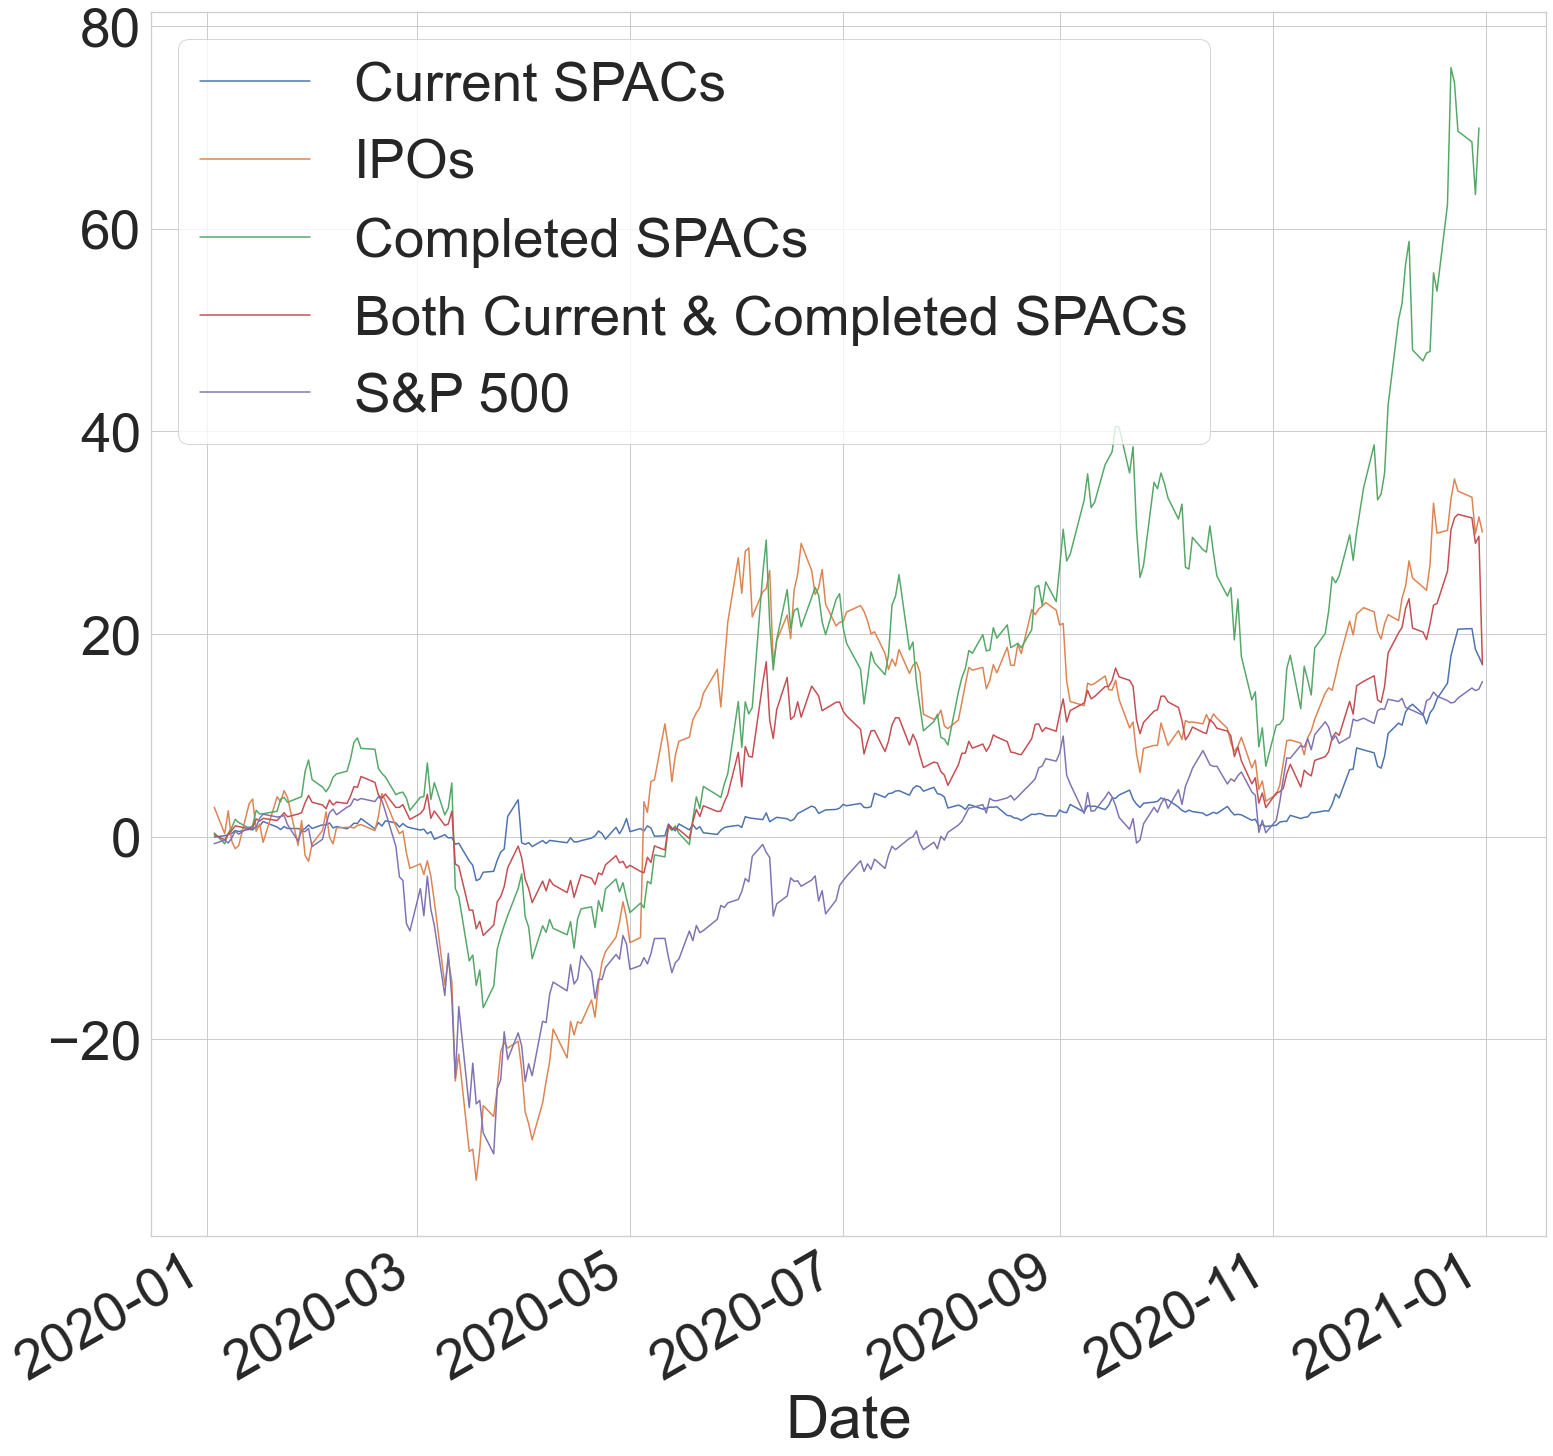

In [12]:
SPACs_daily_mean_pct.plot(figsize=(25,25), legend=True, label="Current SPACs")
IPOs_daily_mean_pct.plot(figsize=(25,25), legend=True, label="IPOs")
Completed_SPACs_daily_mean_pct.plot(figsize=(25,25), legend=True, label="Completed SPACs")
All_SPACs_daily_mean_pct.plot(figsize=(25,25), legend=True, label="Both Current & Completed SPACs")
SP_mean_daily_pct.plot(figsize=(25,25), legend=True, label="S&P 500")

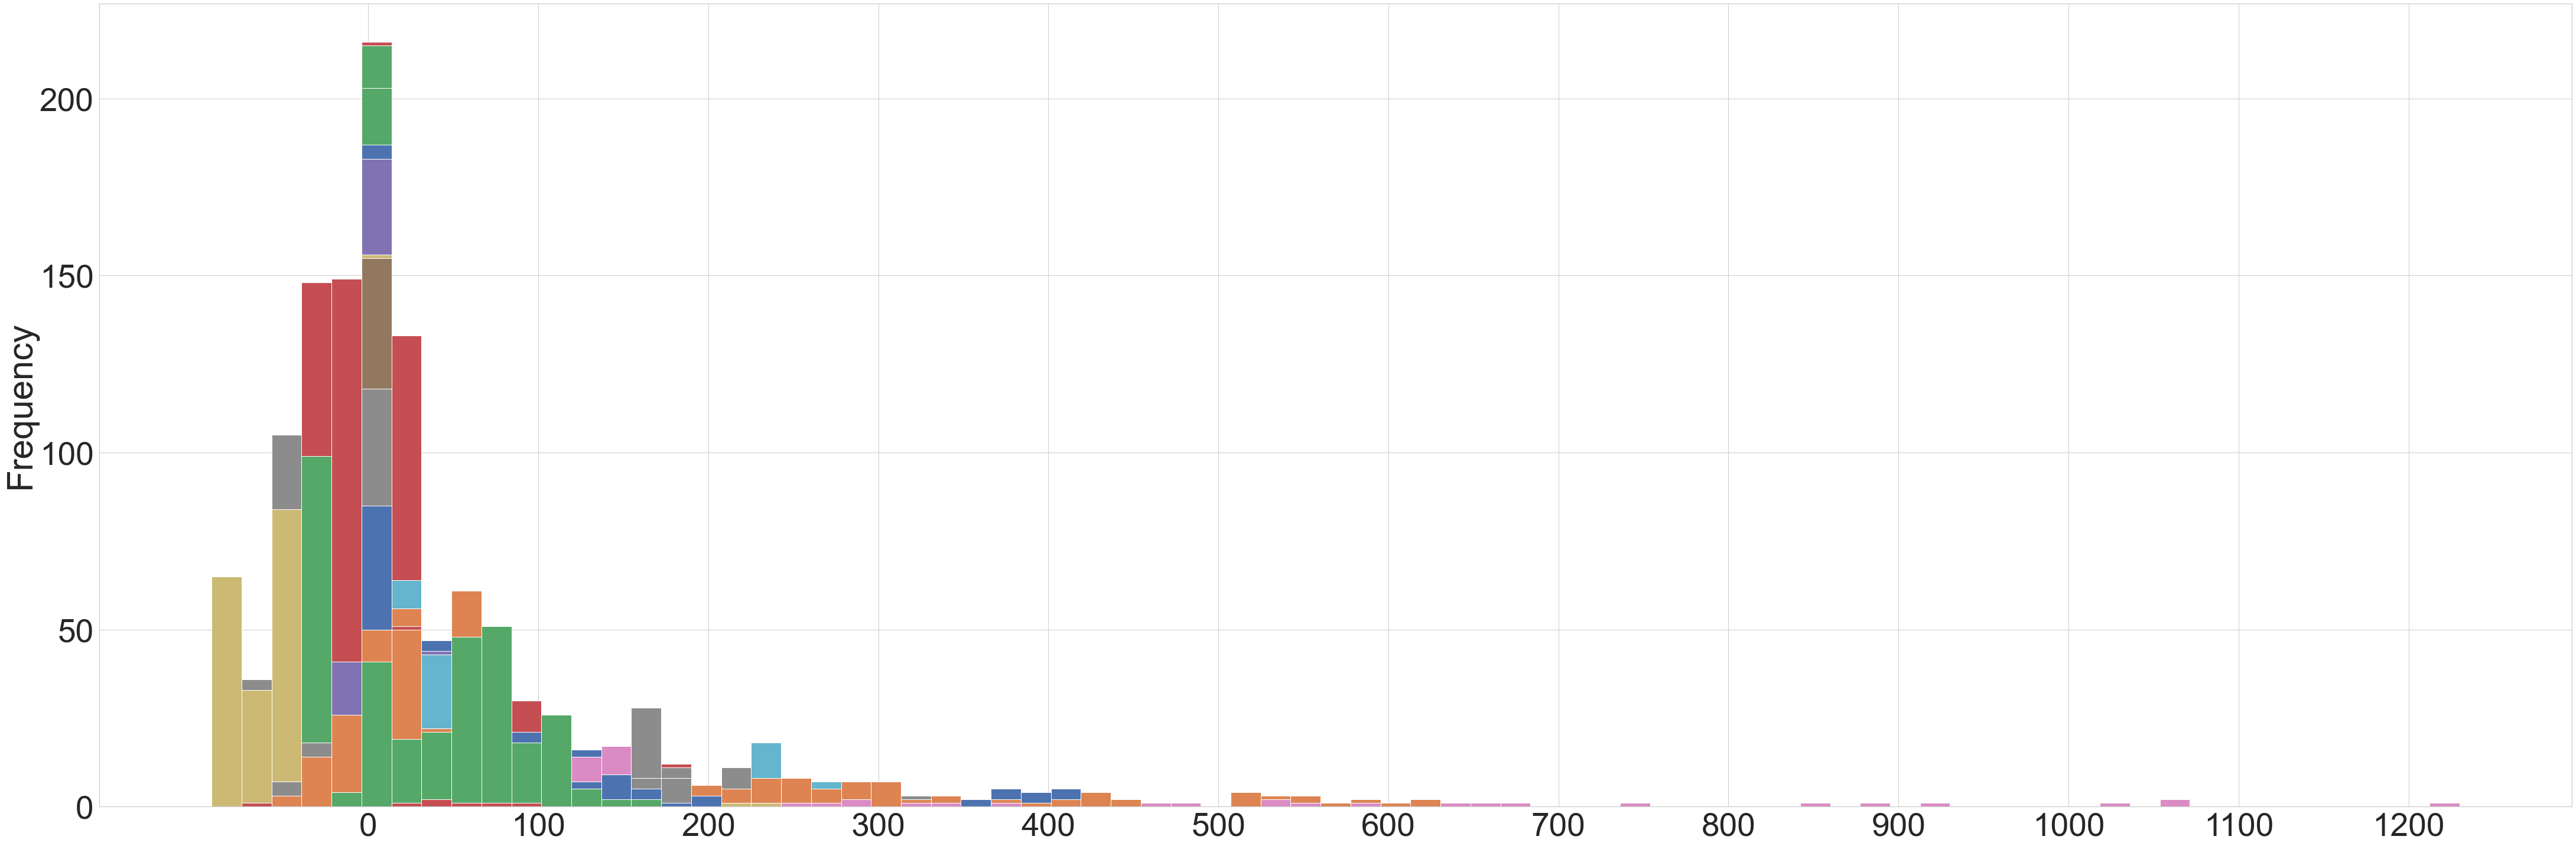

In [745]:
All_SPACs_daily_cum_pct.plot(kind='hist', legend=False, figsize=(75,25), xticks=(np.arange(0,1300,100)), bins=75)

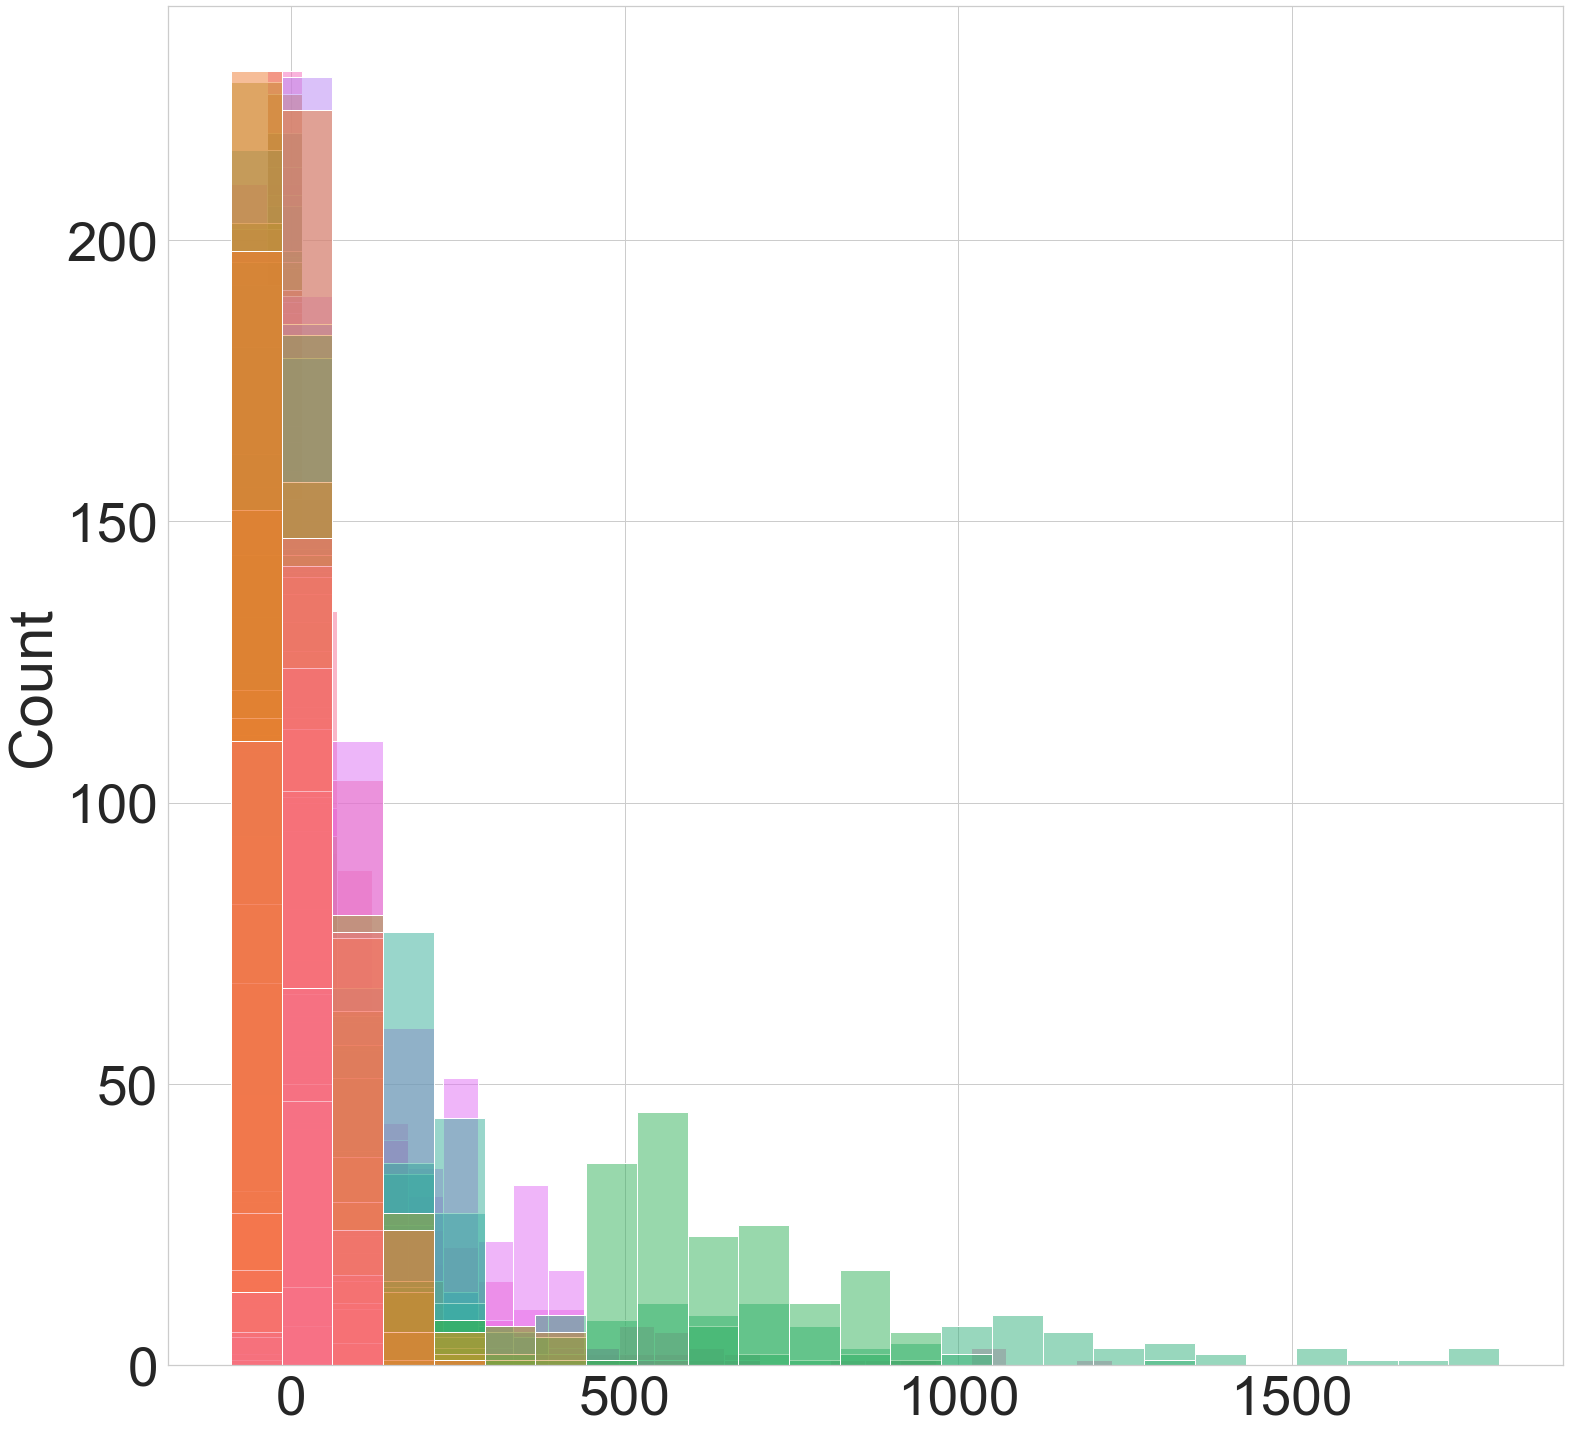

In [165]:
sns.histplot(All_SPACs_daily_cum_pct, bins=25, legend=False, color='red', alpha=.5)
sns.histplot(IPOs_daily_cum_pct, bins=25, legend=False, color='blue', alpha=.5)

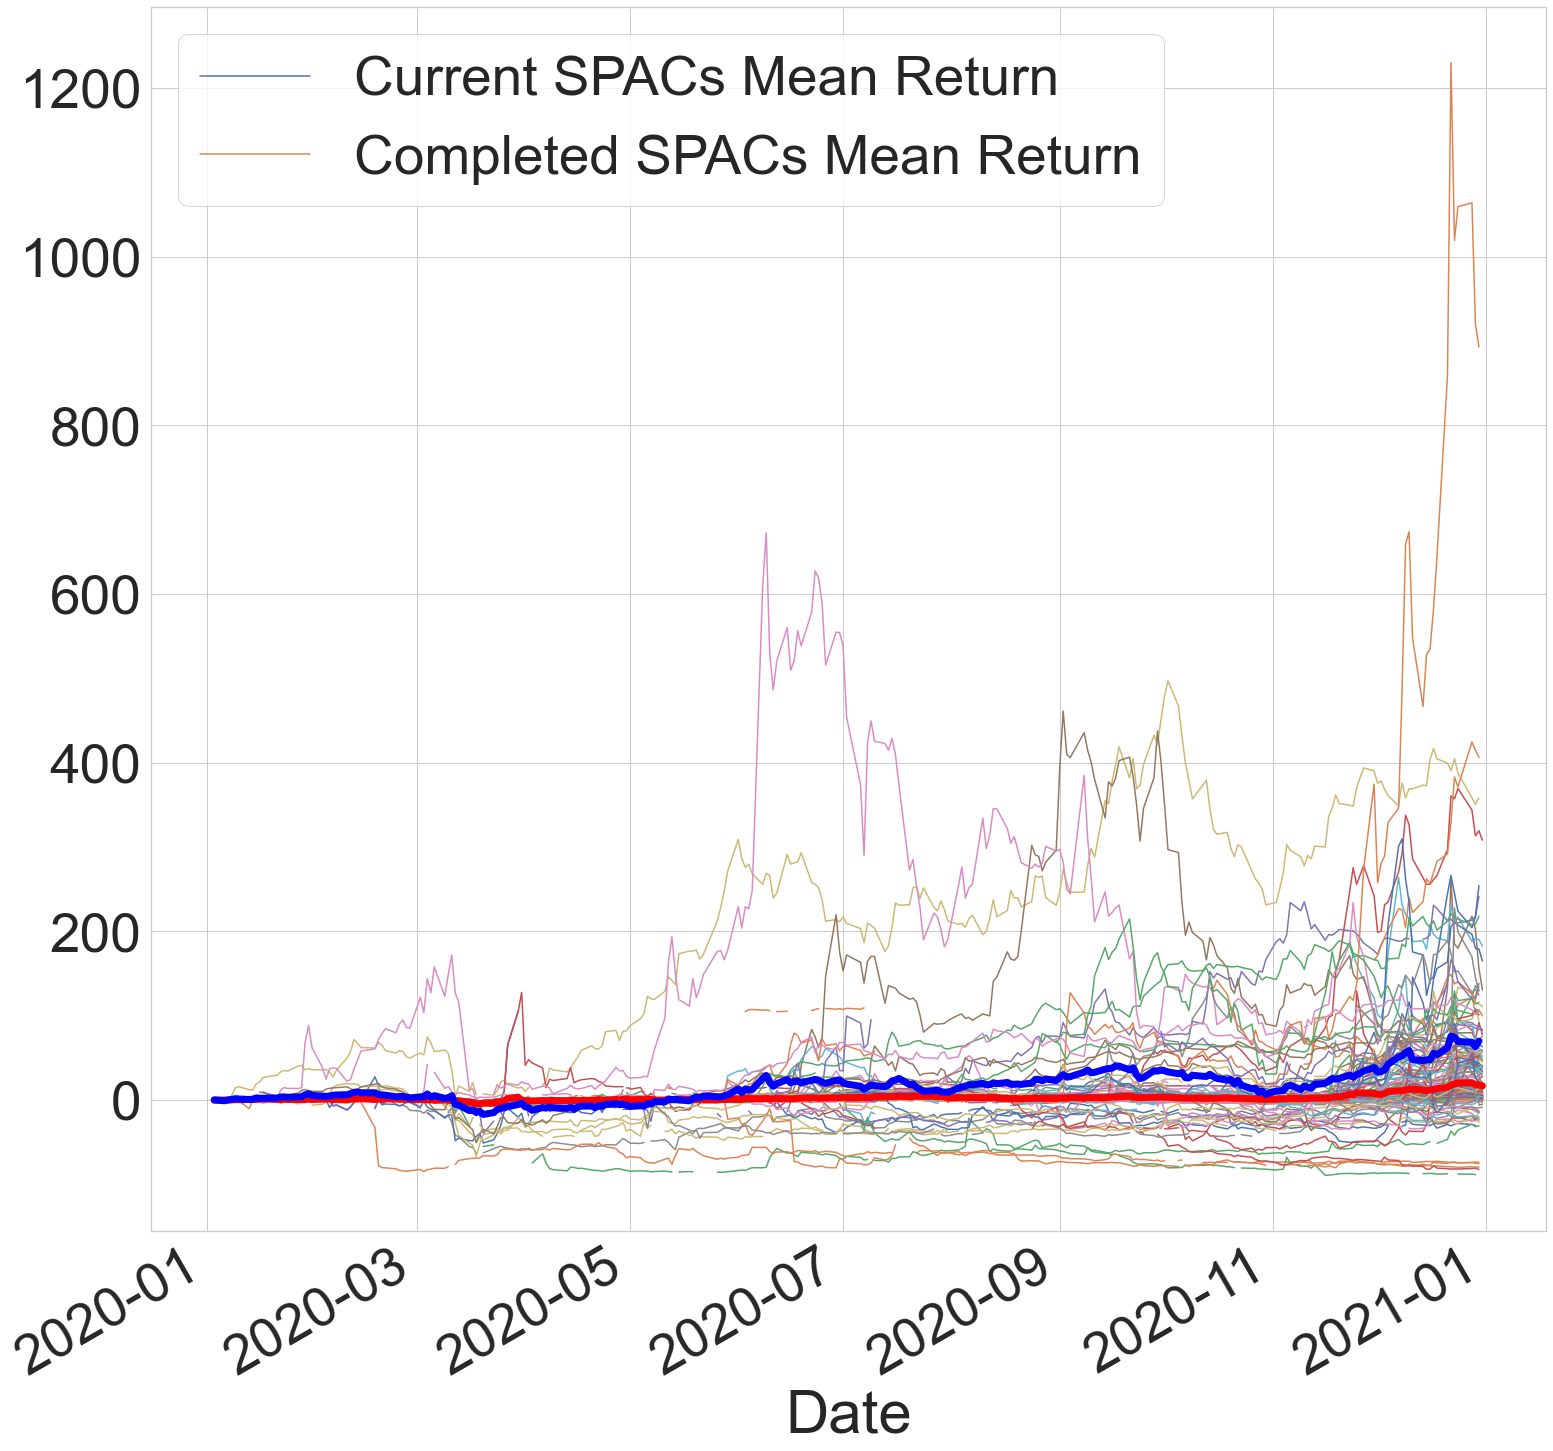

In [312]:
All_SPACs_daily_cum_pct.plot(figsize=(25,25), legend=False)
SPACs_daily_mean_pct.plot(linewidth=7, color='red', legend=True, label='Current SPACs Mean Return')
Completed_SPACs_daily_mean_pct.plot(linewidth=7, color='blue', legend=True, label='Completed SPACs Mean Return')

In [122]:
All_SPAC_returns_max=pd.DataFrame(All_SPAC_returns.max())
All_SPAC_returns_max

,0
AACQ,10.630000
ACAC,10.700000
ACAM,11.360000
ACEV,10.260000
ACIC,10.440000
...,...
VINC,20.500000
VLDR,27.379999
VRT,19.910000
VVNT,27.980000


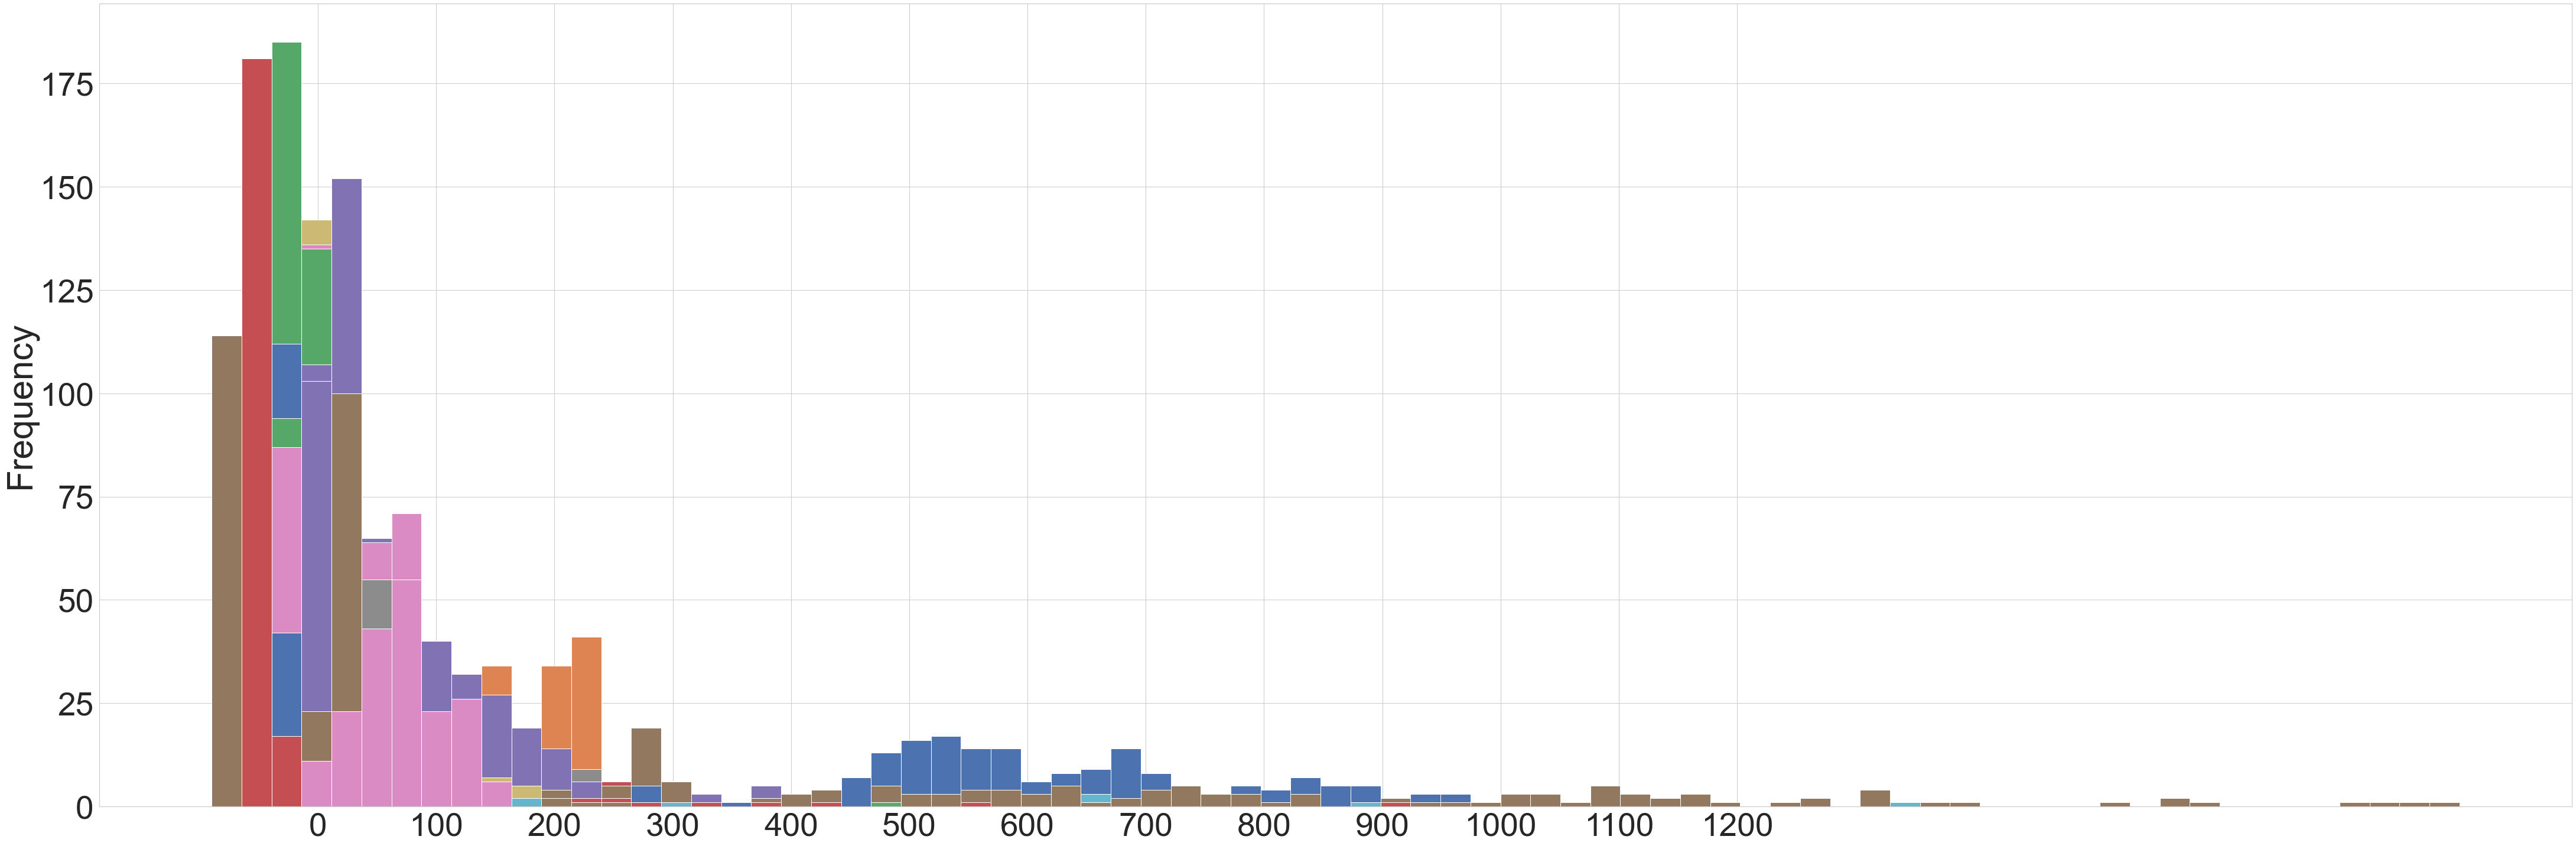

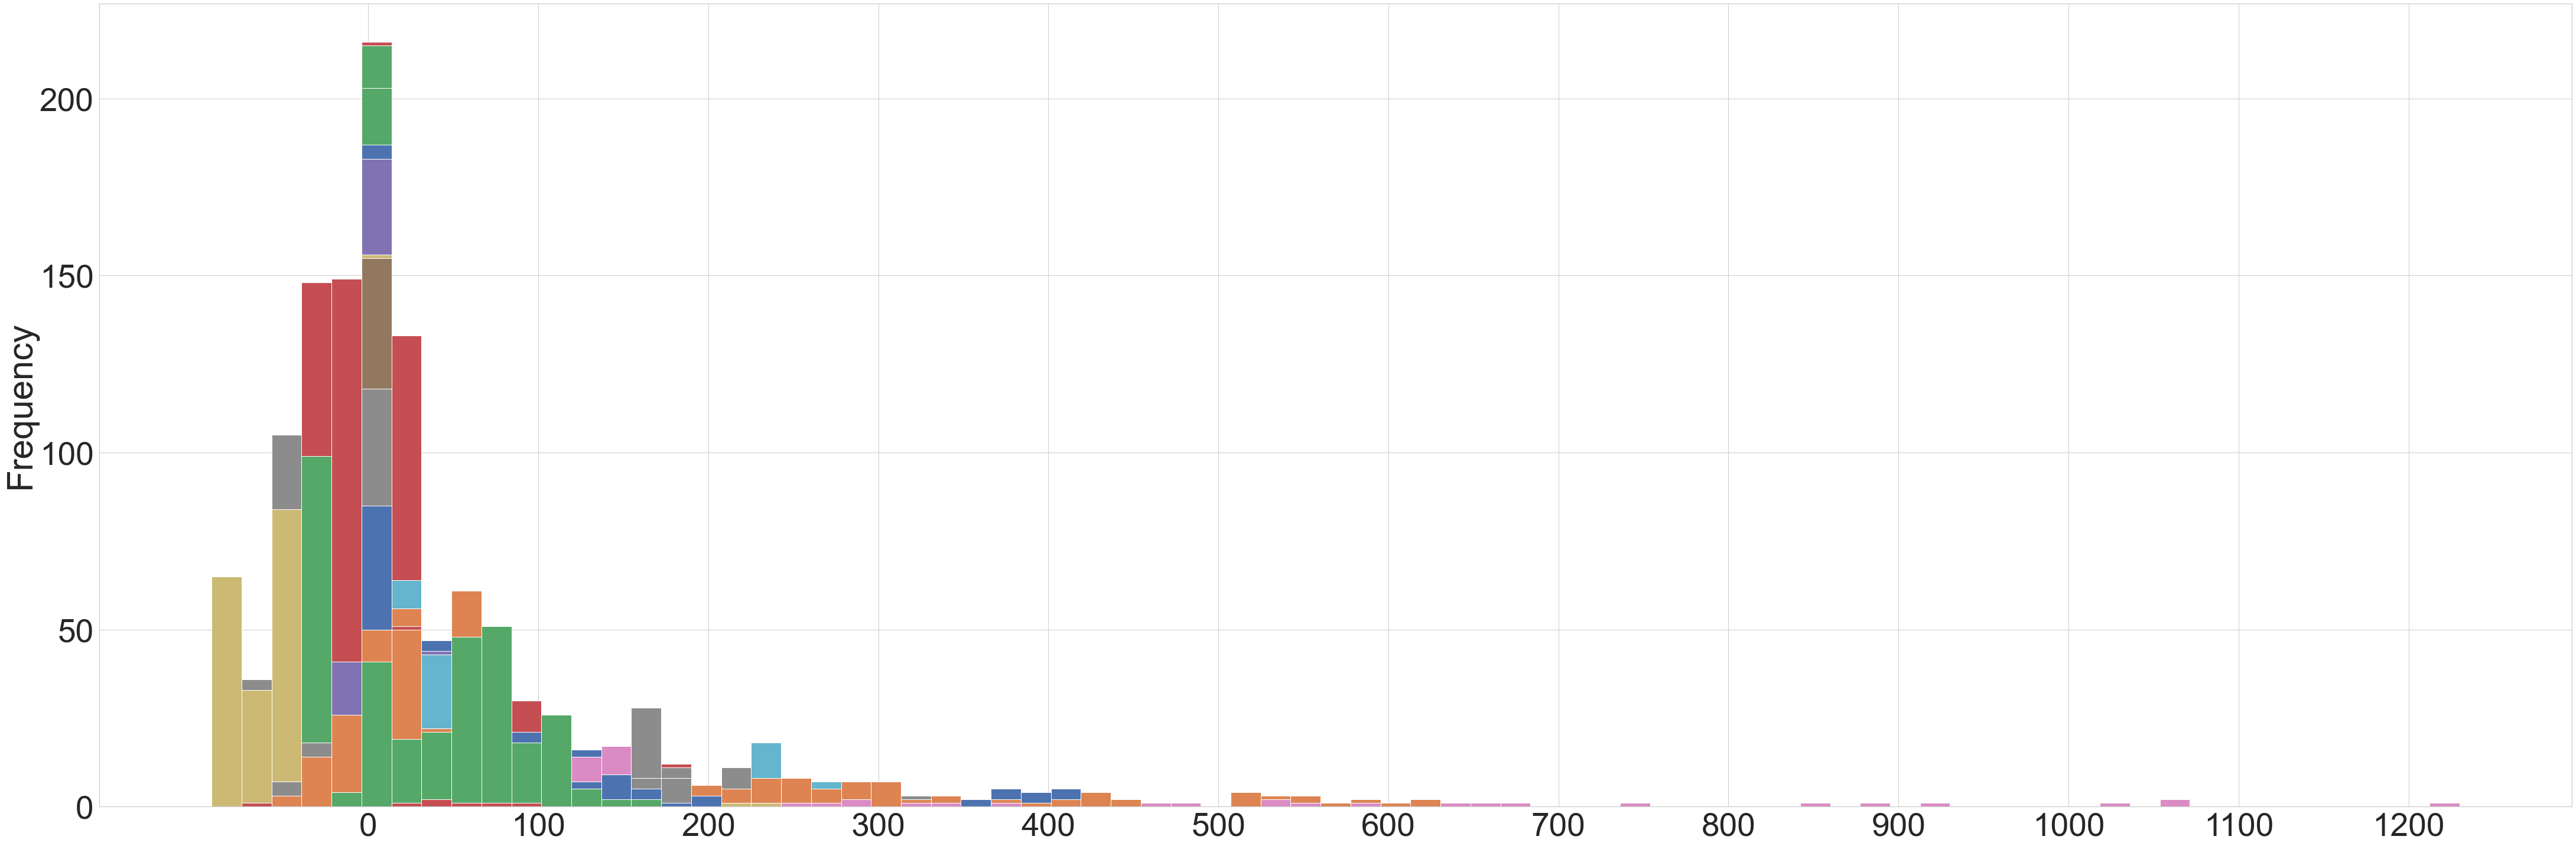

In [748]:
IPOs_daily_cum_pct.plot(kind='hist', legend=False, figsize=(75,25), xticks=(np.arange(0,1300,100)), bins=75)
All_SPACs_daily_cum_pct.plot(kind='hist', legend=False, figsize=(75,25), xticks=(np.arange(0,1300,100)), bins=75)

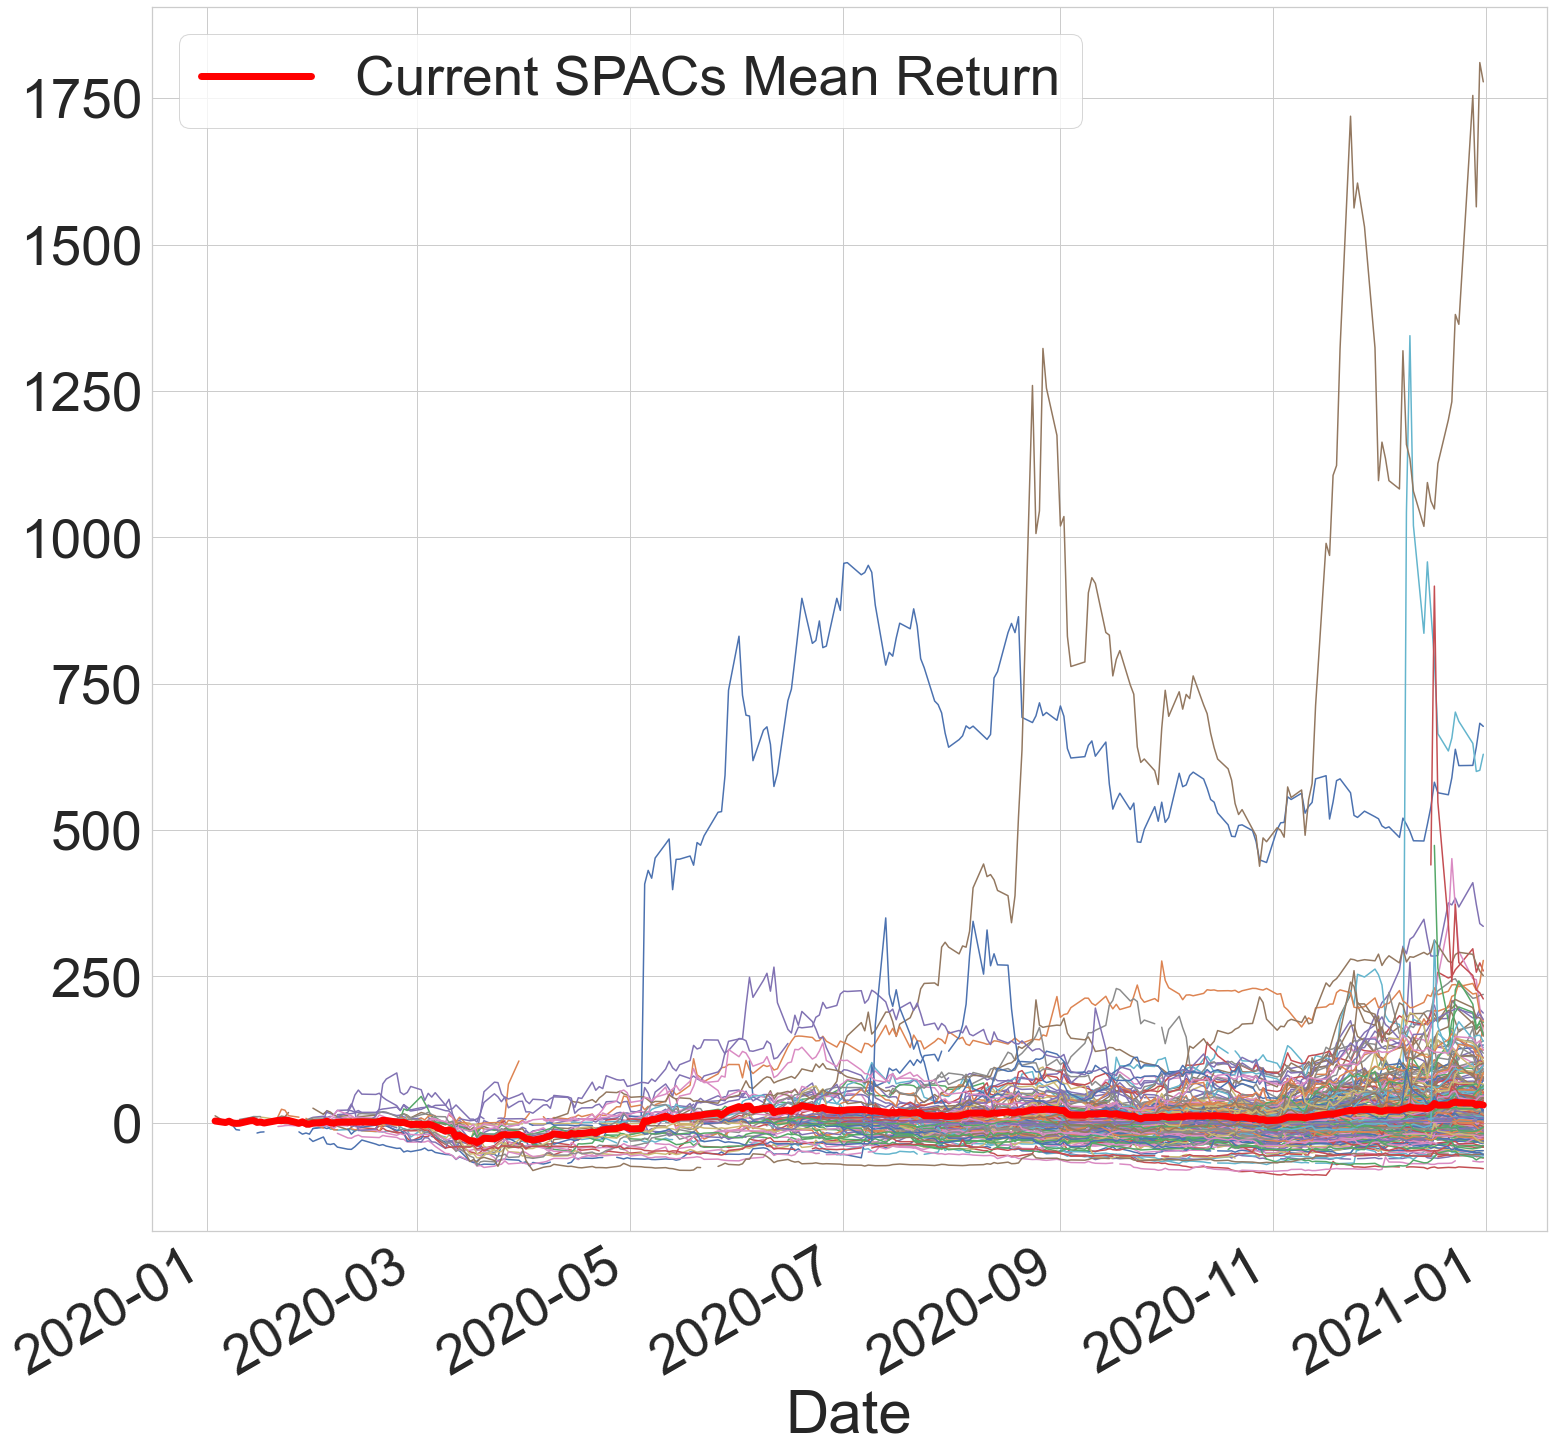

In [749]:
IPOs_daily_cum_pct.plot(legend=False, figsize=(25,25))
IPOs_daily_cum_pct.plot(linewidth=7, color='red', legend=True, label='Current SPACs Mean Return')